In [1]:
import os

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import Model
from flow_layers import parametric_real_nvp # For vector parameteric maps

# Plotting
import matplotlib.pyplot as plt

In [2]:
def StableVariable(m, alpha):
     V = np.pi/2 * (2*np.random.rand(m)-1)
     W = np.random.exponential(scale=1, size=m)
     y = np.sin(alpha * V) / (np.cos(V)**(1/alpha) ) * (np.cos( V*(1-alpha)) / W )**((1-alpha)/alpha)
     return y

def data_generation(T, dt, n_samples):
    t = np.arange(0, T, dt)
    
    Nt = len(t)
    # #multimodal initial distribution
    # mu = np.array([[2, 3]])
    # sigma = np.eye(2)
    # X0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    # XX0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    
    
    #single-model initial distribution
    X0 = np.random.randn(n_samples//2,2)
    XX0 = np.random.randn(n_samples//2,2)
    
    # #fixed initial value
    # X0 = np.ones([n_samples//2,2])
    # XX0 = np.ones([n_samples//2,2])   
    
    
    x0 = X0[:,0:1]
    xx0 = XX0[:,0:1]
    y0 = X0[:,1:]
    yy0 = XX0[:,1:]
    N = len(x0) + len(xx0)
    alpha = 1.5
    x = np.zeros((Nt, N))
    y = np.zeros((Nt, N))
    x[0, 0:n_samples//2] = x0.squeeze()
    x[0, n_samples//2:n_samples] = xx0.squeeze()
    y[0, 0:n_samples//2] = y0.squeeze()
    y[0, n_samples//2:n_samples] = yy0.squeeze()
    for i in range(Nt-1):
        Ut = dt**(1/alpha) * StableVariable(N, alpha)
        Vt = dt**(1/alpha) * StableVariable(N, alpha)
        UUt = dt**(1/2) * np.random.randn(N)
        VVt = dt**(1/2) * np.random.randn(N)
        # #Multimodal case
        # x[i+1, :] = x[i, :] + (8*x[i, :] - 1*x[i, :]**3)*dt + 0*x[i, :]*UUt+ 1*UUt
        # y[i+1, :] = y[i, :] + (8*y[i, :] - 1*y[i, :]**3)*dt + 0*y[i, :]*VVt + 1*VVt
        
        # #Unimodal case
        x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
        y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
     
        b=np.empty(0).astype(int)
        for j in range(n_samples):
            if (np.abs(x[:,j])>1e4).any() or (np.abs(y[:,j])>1e4).any():
                b = np.append(b,j)
        x1 = np.delete(x,b,axis=1)
        y1 = np.delete(y,b,axis=1)
    return t.astype('float64'), x1.astype('float64'), y1.astype('float64')

#Build the model which does basic map of inputs to coefficients
class normalizing_flow(Model):
    def __init__(self,data,params):
        super(normalizing_flow, self).__init__()

        self.dim = data.shape[1]
        self.data = data
        self.params = params

        # Define real_nvp flow layers
        self.l0 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l1 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l2 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l3 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        

        # Training optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Moving statistics
        self.moving_mean = None
        self.moving_std = None

    @tf.function
    def call(self, x, params):

        h1, ldj1 = self.l0(x,params) # Individual layer calls
        h2, ldj2 = self.l1(h1,params)
        h3, ldj3 = self.l2(h2,params)
        hfinal, ldj4 = self.l3(h3,params)

        logdet = ldj1+ldj2+ldj3+ldj4

        log_prior = -0.5*tf.math.reduce_sum(tf.math.square(hfinal))

        neg_ll = - log_prior - logdet

        return hfinal, neg_ll

    @tf.function
    def sample(self,size,params):
        z = tf.random.normal(shape=(size,self.dim),dtype='float64')

        h = self.l3.invert(z,params) # Individual layer calls
        h = self.l2.invert(h,params) # Individual layer calls
        h = self.l1.invert(h,params) # Individual layer calls
        h = self.l0.invert(h,params) # Individual layer calls

        return h,z 

    @tf.function
    def sample_structured(self,z,size,params):
        h = self.l3.invert(z,params) # Individual layer calls
        h = self.l2.invert(h,params) # Individual layer calls
        h = self.l1.invert(h,params) # Individual layer calls
        h = self.l0.invert(h,params) # Individual layer calls

        return h

    # perform gradient descent
    @tf.function
    def network_learn(self,x,params):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            _, neg_ll = self.call(x,params)
            g = tape.gradient(neg_ll, self.trainable_variables)

        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    @tf.function
    def extract_gradient(self,z,params):
        num_samples = params.shape[0]
        params = tf.convert_to_tensor(params)
        z = tf.convert_to_tensor(z)

        with tf.GradientTape() as tape:
            tape.watch(params)
            h = self.sample_structured(z,num_samples,params)
            g = tape.gradient(h, params)

        return g


    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_valid_loss = np.inf # Some large number 

        self.num_batches = 10
        self.ntrain = int(0.7*self.data.shape[0])
        self.nvalid = self.data.shape[0] - int(0.7*self.data.shape[0])

        self.train_data = self.data[:self.ntrain]
        self.train_params = self.params[:self.ntrain]

        self.valid_data = self.data[self.ntrain:]
        self.valid_params = self.params[self.ntrain:]

        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.ntrain/self.num_batches)
        
        for i in range(2000):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                batch_data = self.train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                batch_params = self.train_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(batch_data,batch_params)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                batch_data = self.valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                batch_params = self.valid_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                valid_loss = valid_loss + np.sum(self.call(batch_data,batch_params)[1].numpy())

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation negative log likelihood from:',best_valid_loss,' to:', valid_loss)
                
                best_valid_loss = valid_loss

                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation negative log likelihood (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                self.train_op._hyper['learning_rate'] = 0.5*self.train_op._hyper['learning_rate']
                
                if self.train_op._hyper['learning_rate'] < 1e-6:
                    break

def visualize_samples(samples,params,time=0,eps=0.1):
    # At a specific time
    plot_samples = []
    for i in range(params.shape[0]):
        if params[i,0] < time+eps and params[i,0] > time-eps:
            plot_samples.append(samples[i])

    plot_samples = np.asarray(plot_samples)
    print(plot_samples.shape)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Density at time:'+str(time))
    plt.show()

In [3]:
train_mode = True

final_time = 1.0
timestep = 0.001
num_samples = 400
t, x, y = data_generation(final_time,timestep,num_samples)
t = np.repeat(t.reshape(-1,1),num_samples,axis=-1)

In [4]:
num_train_samples = int(0.8*num_samples)

In [5]:
idx = np.arange(start=0,stop=t.shape[1])
np.random.shuffle(idx)

x_train = x[:,idx[:num_train_samples]].reshape(-1,1)
y_train = y[:,idx[:num_train_samples]].reshape(-1,1)
train_data = np.concatenate((x_train,y_train),axis=-1)
train_params = t[:,idx[:num_train_samples]].reshape(-1,1)

x_test = x[:,idx[num_train_samples:]].reshape(-1,1)
y_test = y[:,idx[num_train_samples:]].reshape(-1,1)
test_data = np.concatenate((x_test,y_test),axis=-1)
test_params = t[:,idx[num_train_samples:]].reshape(-1,1)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# train_data = scaler.fit_transform(train_data)
# test_data = scaler.transform(test_data)

In [6]:
# Normalizing flow training
flow_model = normalizing_flow(train_data,train_params)
pre_samples, source_samples = flow_model.sample(test_data.shape[0],test_params)
pre_samples = pre_samples.numpy()
source_samples = source_samples.numpy()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


(7920, 2)


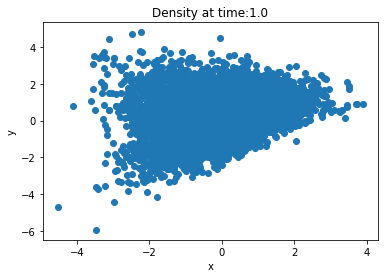

In [7]:
visualize_samples(pre_samples,test_params,time=final_time)

(32000, 2)


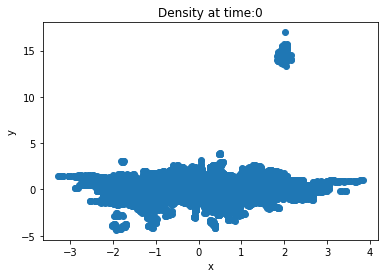

(8000, 2)


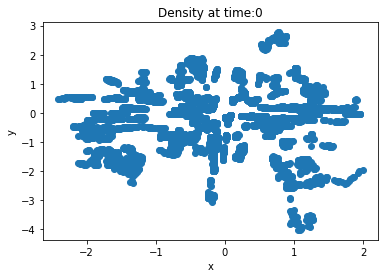

In [8]:
visualize_samples(train_data,train_params,time=0)
visualize_samples(test_data,test_params,time=0)

In [9]:
if train_mode:
    flow_model.train_model()
else:
    flow_model.load_weights('./checkpoints/my_checkpoint')

Training iteration: 0
Improved validation negative log likelihood from: inf  to: 376569.3609522456
Training iteration: 1
Improved validation negative log likelihood from: 376569.3609522456  to: 286453.7047795742
Training iteration: 2
Improved validation negative log likelihood from: 286453.7047795742  to: 272955.5794212926
Training iteration: 3
Improved validation negative log likelihood from: 272955.5794212926  to: 260515.35542952194
Training iteration: 4
Improved validation negative log likelihood from: 260515.35542952194  to: 251016.78516766866
Training iteration: 5
Improved validation negative log likelihood from: 251016.78516766866  to: 244505.8201771283
Training iteration: 6
Validation negative log likelihood (no improvement): 247914.40362350794
Training iteration: 7
Validation negative log likelihood (no improvement): 248917.16979531356
Training iteration: 8
Validation negative log likelihood (no improvement): 247988.4087596167
Training iteration: 9
Validation negative log likel

Validation negative log likelihood (no improvement): 167935.64474886435
Training iteration: 82
Improved validation negative log likelihood from: 166861.21227933062  to: 166687.4622879914
Training iteration: 83
Validation negative log likelihood (no improvement): 169039.02379768755
Training iteration: 84
Validation negative log likelihood (no improvement): 168886.71124449212
Training iteration: 85
Improved validation negative log likelihood from: 166687.4622879914  to: 166194.13564922014
Training iteration: 86
Validation negative log likelihood (no improvement): 166786.3065050383
Training iteration: 87
Validation negative log likelihood (no improvement): 167830.469945004
Training iteration: 88
Validation negative log likelihood (no improvement): 168547.42946398922
Training iteration: 89
Validation negative log likelihood (no improvement): 168483.04428887955
Training iteration: 90
Improved validation negative log likelihood from: 166194.13564922014  to: 164357.96812166413
Training iterat

Validation negative log likelihood (no improvement): 167093.68520710678
Training iteration: 167
Validation negative log likelihood (no improvement): 164699.66651547243
Training iteration: 168
Validation negative log likelihood (no improvement): 170216.0207863765
Training iteration: 169
Validation negative log likelihood (no improvement): 166427.91537686775
Training iteration: 170
Validation negative log likelihood (no improvement): 166727.93847279687
Training iteration: 171
Validation negative log likelihood (no improvement): 163628.99979808996
Training iteration: 172
Validation negative log likelihood (no improvement): 171873.48044203376
Training iteration: 173
Validation negative log likelihood (no improvement): 165626.6992107407
Training iteration: 174
Validation negative log likelihood (no improvement): 168453.01483924084
Training iteration: 175
Validation negative log likelihood (no improvement): 165614.3775430298
Training iteration: 176
Validation negative log likelihood (no impr

Validation negative log likelihood (no improvement): 171606.87869844734
Training iteration: 255
Validation negative log likelihood (no improvement): 168123.98392183732
Training iteration: 256
Validation negative log likelihood (no improvement): 179871.4047054452
Training iteration: 257
Validation negative log likelihood (no improvement): 174145.40792806295
Training iteration: 258
Validation negative log likelihood (no improvement): 171448.95525870827
Training iteration: 259
Validation negative log likelihood (no improvement): 169388.31812560235
Training iteration: 260
Validation negative log likelihood (no improvement): 176845.4970551026
Training iteration: 261
Validation negative log likelihood (no improvement): 171816.85824343545
Training iteration: 262
Validation negative log likelihood (no improvement): 173190.24980837782
Training iteration: 263
Validation negative log likelihood (no improvement): 172261.58938749885
Training iteration: 264
Validation negative log likelihood (no imp

Validation negative log likelihood (no improvement): 178332.27325298014
Training iteration: 342
Validation negative log likelihood (no improvement): 184938.7775914503
Training iteration: 343
Validation negative log likelihood (no improvement): 171360.0735449439
Training iteration: 344
Validation negative log likelihood (no improvement): 186095.7252345145
Training iteration: 345
Validation negative log likelihood (no improvement): 183746.31986611275
Training iteration: 346
Validation negative log likelihood (no improvement): 184215.25214565877
Training iteration: 347
Validation negative log likelihood (no improvement): 173568.7562839916
Training iteration: 348
Validation negative log likelihood (no improvement): 185592.26319448708
Training iteration: 349
Validation negative log likelihood (no improvement): 177223.2276047471
Training iteration: 350
Validation negative log likelihood (no improvement): 185284.99604986463
Training iteration: 351
Validation negative log likelihood (no improv

Validation negative log likelihood (no improvement): 179762.89291169422
Training iteration: 430
Validation negative log likelihood (no improvement): 183180.02945926576
Training iteration: 431
Validation negative log likelihood (no improvement): 194824.24774873
Training iteration: 432
Validation negative log likelihood (no improvement): 199037.03397830212
Training iteration: 433
Validation negative log likelihood (no improvement): 212925.21949175672
Training iteration: 434
Validation negative log likelihood (no improvement): 182254.8663391257
Training iteration: 435
Validation negative log likelihood (no improvement): 208268.81172292298
Training iteration: 436
Validation negative log likelihood (no improvement): 189863.10844494862
Training iteration: 437
Validation negative log likelihood (no improvement): 188085.3823403234
Training iteration: 438
Validation negative log likelihood (no improvement): 185709.3766898173
Training iteration: 439
Validation negative log likelihood (no improve

Validation negative log likelihood (no improvement): 232919.2461745706
Training iteration: 518
Validation negative log likelihood (no improvement): 196760.941181287
Training iteration: 519
Validation negative log likelihood (no improvement): 202887.58886147762
Training iteration: 520
Validation negative log likelihood (no improvement): 190361.44889294676
Training iteration: 521
Validation negative log likelihood (no improvement): 197395.6733447627
Training iteration: 522
Validation negative log likelihood (no improvement): 195815.82838667286
Training iteration: 523
Validation negative log likelihood (no improvement): 204180.3992847832
Training iteration: 524
Validation negative log likelihood (no improvement): 192624.9061981742
Training iteration: 525
Validation negative log likelihood (no improvement): 203865.41891537246
Training iteration: 526
Validation negative log likelihood (no improvement): 193965.33530435816
Training iteration: 527
Validation negative log likelihood (no improve

Validation negative log likelihood (no improvement): 247938.40051381494
Training iteration: 606
Validation negative log likelihood (no improvement): 208688.4286641991
Training iteration: 607
Validation negative log likelihood (no improvement): 225623.08490279125
Training iteration: 608
Validation negative log likelihood (no improvement): 216033.88896414338
Training iteration: 609
Validation negative log likelihood (no improvement): 217369.73969751262
Training iteration: 610
Validation negative log likelihood (no improvement): 237281.46912706655
Training iteration: 611
Validation negative log likelihood (no improvement): 242589.6159789814
Training iteration: 612
Validation negative log likelihood (no improvement): 231455.16054654776
Training iteration: 613
Validation negative log likelihood (no improvement): 231085.70479577617
Training iteration: 614
Validation negative log likelihood (no improvement): 216461.14794318978
Training iteration: 615
Validation negative log likelihood (no imp

Validation negative log likelihood (no improvement): 238420.04315754827
Training iteration: 694
Validation negative log likelihood (no improvement): 264540.60173436685
Training iteration: 695
Validation negative log likelihood (no improvement): 239107.0734273048
Training iteration: 696
Validation negative log likelihood (no improvement): 261294.04476355592
Training iteration: 697
Validation negative log likelihood (no improvement): 239970.30822329829
Training iteration: 698
Validation negative log likelihood (no improvement): 260694.8087262315
Training iteration: 699
Validation negative log likelihood (no improvement): 229034.56562016407
Training iteration: 700
Validation negative log likelihood (no improvement): 256237.6845602033
Training iteration: 701
Validation negative log likelihood (no improvement): 193373.14267116773
Training iteration: 702
Validation negative log likelihood (no improvement): 242178.6345626121
Training iteration: 703
Validation negative log likelihood (no impro

Validation negative log likelihood (no improvement): 168318.9133254007
Training iteration: 782
Validation negative log likelihood (no improvement): 165962.44045711134
Training iteration: 783
Validation negative log likelihood (no improvement): 172092.4579719978
Training iteration: 784
Validation negative log likelihood (no improvement): 166118.5713356341
Training iteration: 785
Validation negative log likelihood (no improvement): 167207.80835877324
Training iteration: 786
Validation negative log likelihood (no improvement): 167908.30148649562
Training iteration: 787
Validation negative log likelihood (no improvement): 170671.2004570553
Training iteration: 788
Validation negative log likelihood (no improvement): 166860.0563430037
Training iteration: 789
Validation negative log likelihood (no improvement): 168984.65168856014
Training iteration: 790
Validation negative log likelihood (no improvement): 168927.02398076458
Training iteration: 791
Validation negative log likelihood (no improv

Validation negative log likelihood (no improvement): 175241.0574377312
Training iteration: 870
Validation negative log likelihood (no improvement): 169306.50115652368
Training iteration: 871
Validation negative log likelihood (no improvement): 171385.5039997883
Training iteration: 872
Validation negative log likelihood (no improvement): 172215.79169685874
Training iteration: 873
Validation negative log likelihood (no improvement): 176025.06281816302
Training iteration: 874
Validation negative log likelihood (no improvement): 170163.20553220567
Training iteration: 875
Validation negative log likelihood (no improvement): 175959.2098772155
Training iteration: 876
Validation negative log likelihood (no improvement): 173452.1034060321
Training iteration: 877
Validation negative log likelihood (no improvement): 170973.3852728728
Training iteration: 878
Validation negative log likelihood (no improvement): 171967.16815725004
Training iteration: 879
Validation negative log likelihood (no improv

Validation negative log likelihood (no improvement): 182155.34685928744
Training iteration: 958
Validation negative log likelihood (no improvement): 189159.6673168599
Training iteration: 959
Validation negative log likelihood (no improvement): 191770.28114243053
Training iteration: 960
Validation negative log likelihood (no improvement): 192947.17770632086
Training iteration: 961
Validation negative log likelihood (no improvement): 187522.3708745242
Training iteration: 962
Validation negative log likelihood (no improvement): 194331.27796756593
Training iteration: 963
Validation negative log likelihood (no improvement): 199449.47024238855
Training iteration: 964
Validation negative log likelihood (no improvement): 206548.77067463164
Training iteration: 965
Validation negative log likelihood (no improvement): 182287.6676508342
Training iteration: 966
Validation negative log likelihood (no improvement): 190656.88688320713
Training iteration: 967
Validation negative log likelihood (no impr

Validation negative log likelihood (no improvement): 3096643255943.0605
Training iteration: 1046
Validation negative log likelihood (no improvement): 419852847.6758898
Training iteration: 1047
Validation negative log likelihood (no improvement): 111965461.64260718
Training iteration: 1048
Validation negative log likelihood (no improvement): 575151420.5820158
Training iteration: 1049
Validation negative log likelihood (no improvement): 8152554883.663
Training iteration: 1050
Validation negative log likelihood (no improvement): 2694702668.4538
Training iteration: 1051
Validation negative log likelihood (no improvement): 29549773.613282092
Training iteration: 1052
Validation negative log likelihood (no improvement): 2558113031.126147
Training iteration: 1053
Validation negative log likelihood (no improvement): 4577617114581.028
Training iteration: 1054
Validation negative log likelihood (no improvement): 5314142056.949793
Training iteration: 1055
Validation negative log likelihood (no imp

KeyboardInterrupt: 

In [15]:
flow_model.load_weights('./checkpoints/my_checkpoint')

In [17]:
post_samples, source_samples = flow_model.sample(train_data.shape[0],train_params)
post_samples = post_samples.numpy()

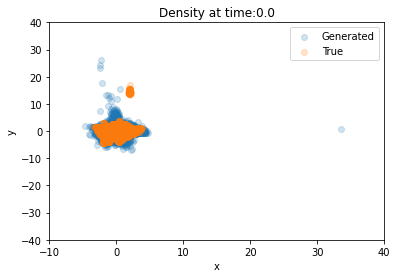

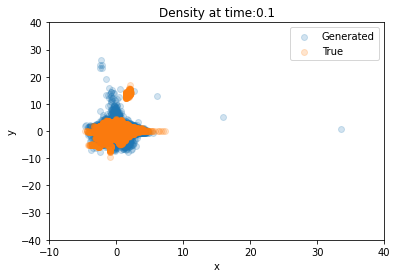

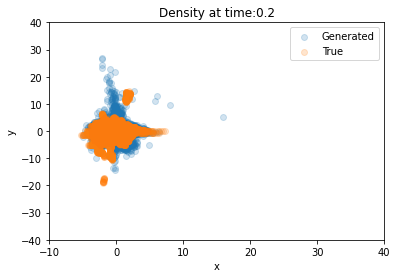

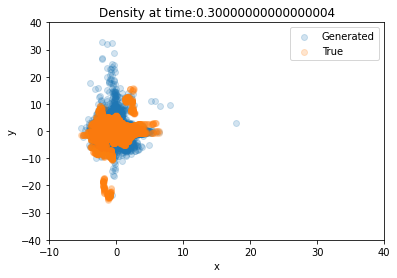

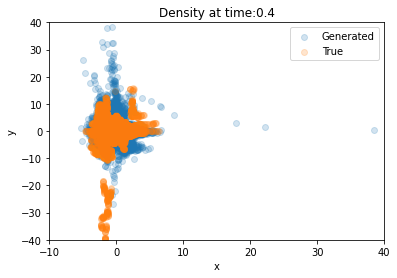

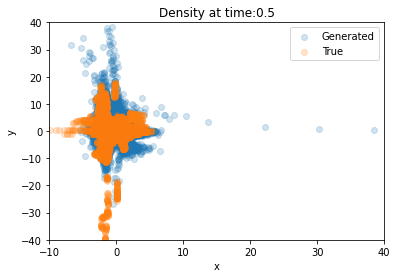

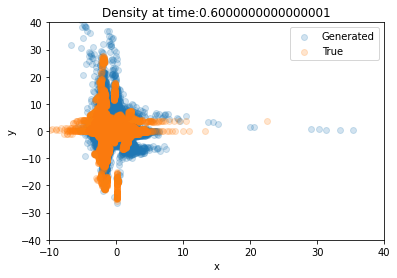

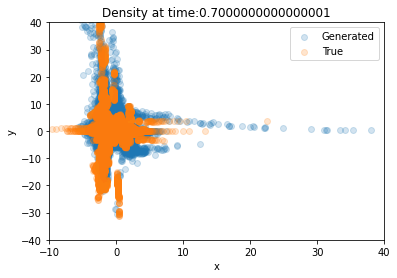

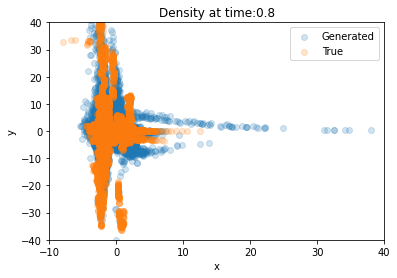

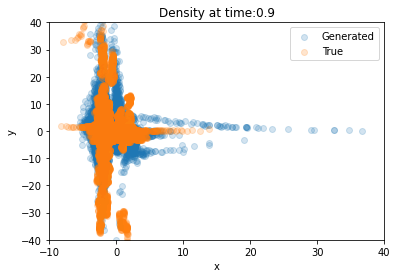

In [20]:
# At a specific time
for time in np.arange(0.0,final_time,0.1):
    
    eps = 0.1
    plot_samples = []
    target_samples = []

    for i in range(train_params.shape[0]):
        if train_params[i,0] < time+eps and train_params[i,0] > time-eps:
            plot_samples.append(post_samples[i])
            target_samples.append(train_data[i])

    plot_samples = np.asarray(plot_samples)
    target_samples = np.asarray(target_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1],label='Generated',alpha=0.2)
    plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2,label='True')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((-10,40))
    plt.ylim((-40,40))
    plt.title('Density at time:'+str(time))
    plt.legend()
    plt.show()

In [29]:
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)

xv, yv = np.meshgrid(x, y)
xvflat = xv.reshape(-1,1)
yvflat = yv.reshape(-1,1)

grid = np.concatenate((xvflat,yvflat),axis=-1)
params = np.zeros(shape=(grid.shape[0],1))

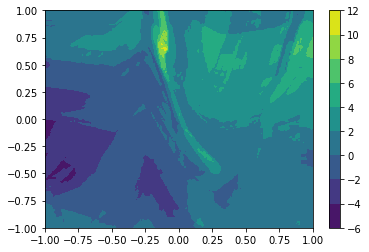

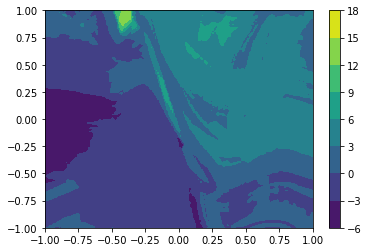

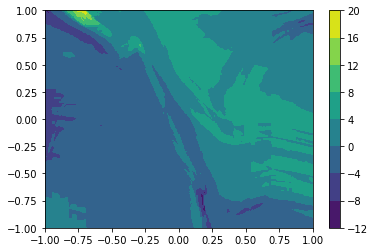

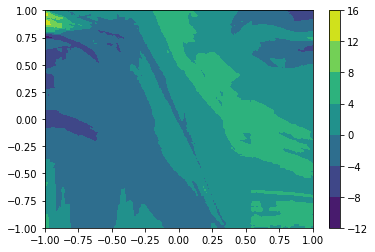

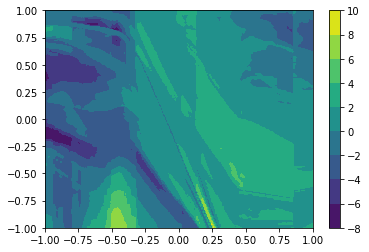

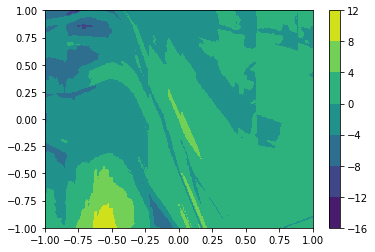

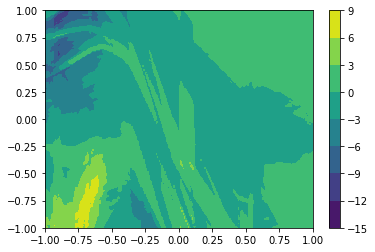

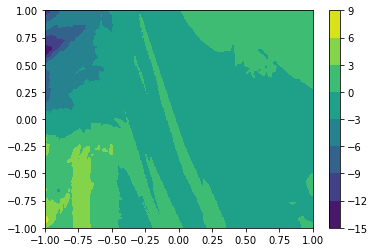

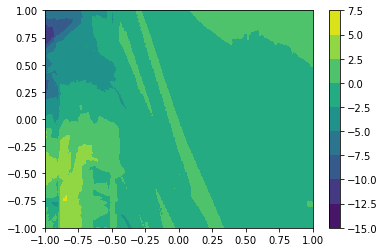

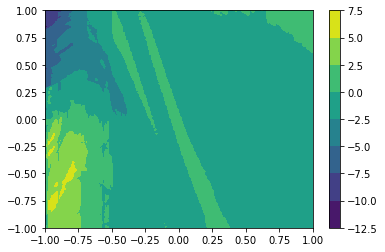

In [30]:
for time in np.arange(0.0,final_time,0.1):
    params[:,0] = time
    gradients = flow_model.extract_gradient(grid,params)
    gradients = np.nan_to_num(gradients.numpy().reshape(200,200))
    
    plt.figure()
    plt.contourf(xv,yv,gradients)
    plt.colorbar()
    plt.show